# Gaussian Mixture Model:GMM

Define GMM as a mixture model which raito is $\pi_k$

$$
p(\boldsymbol{x} | \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma})=\sum_{k=1}^{K} {\pi_{k}}{\mathcal{N}}\left(\boldsymbol{x} | \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)
$$

In [214]:
import os
import numpy as np
import numpy.random as rd
import scipy as sp
from scipy import stats as st
from collections import Counter

import matplotlib
matplotlib.use('Agg')
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
import imageio
import glob
from PIL import Image
import datetime

check:  0 [0. 0.] [[1. 0.]
 [0. 2.]] 2.0
check:  1 [8. 4.] [[1. 0.]
 [0. 1.]] 1.0
check:  2 [16. 16.] [[1.16516742 1.04517218]
 [1.04517218 1.70517305]] 0.8944271909999172


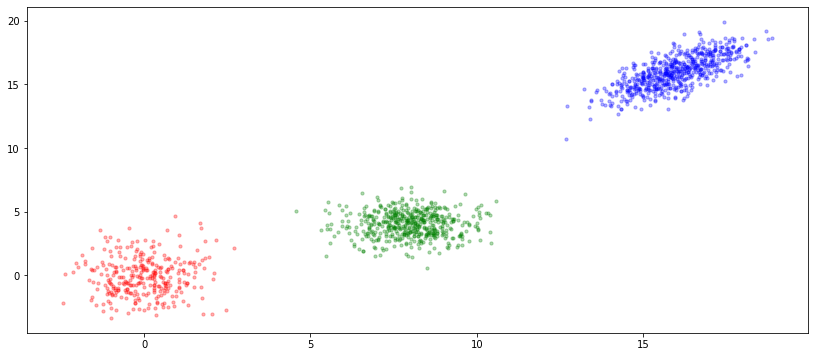

In [120]:
seed = 0
n = [300, 500, 600]
N = np.sum(n)
mu_true = np.asanyarray(
     [[0, 0],
      [8., 4.],
      [16., 16.]])

D = mu_true.shape[1]

sigma_true = np.asanyarray(
        [ sp.linalg.sqrtm(np.diag((1,4))),
          [[1.,0],[0, 1.]],
          sp.linalg.sqrtm([[2.45,3],[3,4]])
        ])
c = ['r', 'g', 'b']

rd.seed(seed)
org_data = None
for i in range(3):
    print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))
    if org_data is None: org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
    else:                org_data = np.r_[org_data, np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]]
# plot generated data        
plt.figure(figsize=(14, 6))
for i in range(3): plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=10, c=c[i], alpha=0.3)
    
# drop true cluster label
X = org_data[:,0:2].copy()
y = org_data[:,2].copy()
labels = ["r" if i==0 else "g" if i==1 else "b" for i in y]

## Two Types of Data
Complete data: when we know position X and latent variable Z  
Inceomplete data: when we only know position X

latent variable z $\in$ Z is a K dim vector denoting whether observed points belong to some cluster

## EM algorithsm

1. Initialization: set initial values to π,μ,Σ parameters and compute log likelihood.

2. E step:  computete responsibility γ(z_nk)

$$
\begin{aligned} \gamma\left(z_{n k}\right) &=p\left(z_{k}=1 | \boldsymbol{x}\right) \\ &=\frac{p\left(z_{k}=1\right) p\left(\boldsymbol{x} | z_{k}=1\right)}{\sum_{j=1}^{K} p\left(z_{k}=1\right) p\left(\boldsymbol{x} | z_{k}=1\right)} \\ &=\frac{\pi_{k} \mathcal{N}\left(\boldsymbol{x} | \boldsymbol{\mu}_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\boldsymbol{x} | \boldsymbol{\mu}_{j}, \Sigma_{j}\right)} \end{aligned}
$$

3. M step:  differentiate log likelihood function to π,μ,Σ, and find a maximum likelihood solution.

$$
\begin{aligned} \boldsymbol{\mu}_{k}^{*} &=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right) \boldsymbol{x}_{n} \\ \boldsymbol{\Sigma}_{k}^{*} &=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right)\left(\boldsymbol{x}_{n}-\boldsymbol{\mu}_{k}\right)\left(\boldsymbol{x}_{n}-\boldsymbol{\mu}_{k}\right)^{T} \\ \pi_{k} &=\frac{N_{k}}{N}=\frac{\sum_{n=1}^{N} \gamma\left(z_{n k}\right)}{N} \end{aligned}
$$

4. Convergence Check: compute log likelihood again. if the difference to the previous one is not smaller than a convergence condition, go back to 2, else exit.

$$
L_{\text { new }}=\ln p(X | \boldsymbol{\pi}, \boldsymbol{\mu}, \mathbf{\Sigma})=\sum_{n=1}^{N} \ln \left\{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\boldsymbol{x}_{n} | \boldsymbol{\mu}_{j}, \boldsymbol{\Sigma}_{j}\right)\right\}
$$
$$
L_{\mathrm{new}}-L_{\mathrm{old}}<\varepsilon
$$

In [218]:
class GaussianMixtureModel:
    def __init__(self, K, diag=False):
        self.K = K
        self.diag = diag
        self.Pi = None
        self.Mu = None
        self.Sigma = None
                
    def _init_params(self, X, random_state=None):
        '''
        Method for initializing model parameterse based on the size and variance of the input data array. 
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        '''
        n_samples, n_features = np.shape(X)
        rnd = np.random.RandomState(seed=random_state)
        
        self.Pi = np.ones(self.K)/self.K
        self.Mu = X[rnd.choice(n_samples, size=self.K, replace=False)]
        self.Sigma = np.tile(np.diag(np.var(X, axis=0)), (self.K, 1, 1))

        
    def _calc_nmat(self, X):
        '''
        Method for calculating array corresponding $\mathcal{N}(x_n | \mu_k)$
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Nmat : 2D numpy array
            2-D numpy array representing probability density for each sample and each component, 
            where Nmat[n, k] = $\mathcal{N}(x_n | \mu_k)$.
        
        '''
        n_samples, n_features = np.shape(X)
         
        Diff = np.reshape(X, (n_samples, 1, n_features) ) - np.reshape(self.Mu, (1, self.K, n_features) )
        L = np.linalg.inv(self.Sigma)
        exponent = np.einsum("nkj,nkj->nk", np.einsum("nki,kij->nkj", Diff, L), Diff)
        Nmat = np.exp(-0.5*exponent)/np.sqrt(np.linalg.det(self.Sigma))   / (2*np.pi)**(n_features/2)
        return Nmat
        
    def _Estep(self, X):
        '''
        Method for calculating the array corresponding to responsibility.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        
        '''
        n_samples, n_features = np.shape(X)
        Nmat = self._calc_nmat(X)
        tmp = Nmat * self.Pi
        Gam = tmp/np.reshape(np.sum(tmp, axis=1), (n_samples, 1) )
        return Gam
        
    def _Mstep(self, X, Gam):
        '''
        Method for calculating the model parameters based on the responsibility gamma.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        '''
        n_samples, n_features = np.shape(X)
        Diff = np.reshape(X, (n_samples, 1, n_features) ) - np.reshape(self.Mu, (1, self.K, n_features) )
        Nk = np.sum(Gam, axis=0)
        self.Pi = Nk/n_samples
        self.Mu = Gam.T @ X / np.reshape(Nk, (self.K, 1))
        self.Sigma = np.einsum("nki,nkj->kij", np.einsum("nk,nki->nki", Gam, Diff), Diff)/np.reshape(Nk, (self.K, 1, 1))
        if self.diag: 
            for k in range(self.K):
                self.Sigma[k] = np.diag(np.diag(self.Sigma[k]))
        
    def calc_prob_density(self, X):
        '''
        Method for calculating the probablity density $\sum_k \pi_k \mathcal{N}(x_n | \mu_k)$
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        prob_density : 2D numpy array

        '''
        prob_density = self._calc_nmat(X) @ self.Pi
        return prob_density
        
        
    def calc_log_likelihood(self, X):
        '''
        Method for calculating the log-likelihood for the input X and current model parameters.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Returns
        ----------
        loglikelihood : float
            The log-likelihood of the input data X with respect to current parameter set.
        
        '''
        log_likelihood = np.sum(np.log(self.calc_prob_density(X)))
        return log_likelihood
        
        
    def fit(self, X, max_iter, tol, disp_message, random_state=None):
        '''
        Method for performing learning. 
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        max_iter : int
            Maximum number of iteration
        tol : float, positive
            Precision. If the change of parameter is below this value, the iteration is stopped
        disp_message : Boolean
            Whether or not to show the message about the number of iteration
        '''
        self._init_params(X, random_state=random_state)
        LL = []
        log_likelihood = - np.float("inf")
        for i in range(max_iter):
            Gam = self._Estep(X)
            self._Mstep(X, Gam)
            log_likelihood_old = log_likelihood
            log_likelihood = self.calc_log_likelihood(X)
            self.plot_log(X, Gam, LL, i)
            if  log_likelihood - log_likelihood_old < tol: break
                
        if disp_message:
            if self.diag: m = 2
            else:  m= 4
            print(f"K : {self.K}")
            print(f"m : {m}")
            print(f"n_iter : {i}")
            print(f"log_likelihood : {log_likelihood:.3f}")
            print(f"BIC : {calc_BIC(log_likelihood,m,len(X)):.3f}")
            print("")
            
    def predict_proba(self, X):
        '''
        Method for calculating the array corresponding to responsibility. Just a different name for _Estep
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns 
        ----------
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        
        '''
        Gam = self._Estep(X)
        return Gam
    
    def predict(self, X):
        '''
        Method for make prediction about which cluster input points are assigned to.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        pred : 1D numpy array
            1D numpy array, with dtype=int, representing which class input points are assigned to.
        '''
        pred = np.argmax(self.predict_proba(X), axis=1)
        return pred
    
    def plot_log(self,X,Gam,LL,i):
        '''
        Method for plot a log to each iteration
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        LL : list
        log likelihood
        i : int
        epoch 
        '''
        fig = plt.figure(figsize=(12,5))
        xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)
        XX = np.array([xx.ravel(), yy.ravel()]).T
        ll = self.calc_prob_density(XX).reshape(xx.shape)
        LL.append(np.sum(ll))
        im = plt.contour(xx, yy, -ll, alpha=1, zorder=-100, linewidths=0.7, levels=70)  
        plt.title("step %d"%i)
        #plt.savefig("images/gmm_K%d_diag%d/%02d.png"%(self.K,self.diag,i))
        plt.cla()
        im2 = plt.plot(LL)
        plt.title("log-likelihood")
        plt.xlabel("step")
        #fig.savefig("images/gmm2_K%d_diag%d/%02d.png"%(self.K,self.diag,i))
        plt.close()

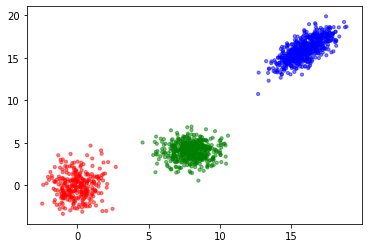

In [219]:
def get_meshgrid(x, y, nx, ny, margin=0.1):
    x_min, x_max = (1 + margin) * x.min() - margin * x.max(), (1 + margin) * x.max() - margin * x.min()
    y_min, y_max = (1 + margin) * y.min() - margin * y.max(), (1 + margin) * y.max() - margin * y.min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    return xx, yy

plt.scatter(X[:,0], X[:,1], c=labels, s=10, alpha=0.5)
xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=N//2, ny=N//2, margin=0.1)

In [220]:
def plot_predicted_label(ax, clf, xx, yy, X, t):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.7)
    ax.scatter(X[:,0], X[:,1], c=t, s=10, alpha=0.5)
    
def plot_prob_density(ax, model, xx, yy, X, t):
    Z = model.calc_prob_density(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.scatter(X[:,0], X[:,1], c=t, s=10, alpha=0.5)
    ax.contour(xx, yy, Z)
    
def plot_result(model, xx, yy, X, t, K=0, diag=False):
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    plt.title("result_label_K%d_diag%d"%(K,diag))
    plot_predicted_label(ax, model, xx, yy, X, t)
    ax = fig.add_subplot(122)
    plt.title("result_dist_K%d_diag%d"%(K,diag))
    plot_prob_density(ax, model, xx, yy, X, t)
    fig.savefig("result/result_K%d_diag%d.png"%(K, diag))
    
def calc_BIC(ll, m, n):
    return -2*ll + m*np.log(n)

K : 1
m : 4
n_iter : 2
log_likelihood : -7682.897
BIC : 15394.772

K : 2
m : 4
n_iter : 15
log_likelihood : -6200.391
BIC : 12429.759

K : 3
m : 4
n_iter : 24
log_likelihood : -5524.239
BIC : 11077.455

K : 4
m : 4
n_iter : 29
log_likelihood : -5522.635
BIC : 11074.246

K : 5
m : 4
n_iter : 29
log_likelihood : -5518.490
BIC : 11065.957

K : 1
m : 2
n_iter : 2
log_likelihood : -9253.312
BIC : 18521.112

K : 2
m : 2
n_iter : 7
log_likelihood : -6896.262
BIC : 13807.012

K : 3
m : 2
n_iter : 9
log_likelihood : -5749.907
BIC : 11514.302

K : 4
m : 2
n_iter : 29
log_likelihood : -5747.517
BIC : 11509.522

K : 5
m : 2
n_iter : 29
log_likelihood : -5743.252
BIC : 11500.993



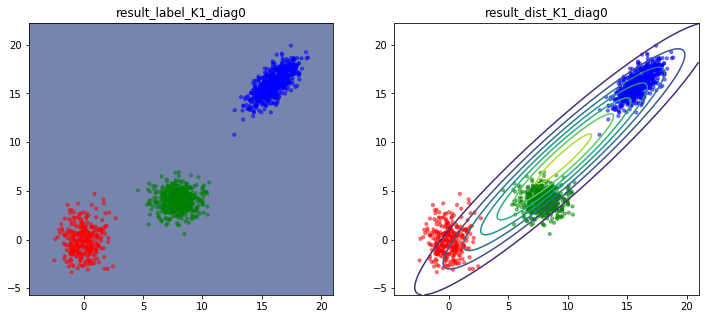

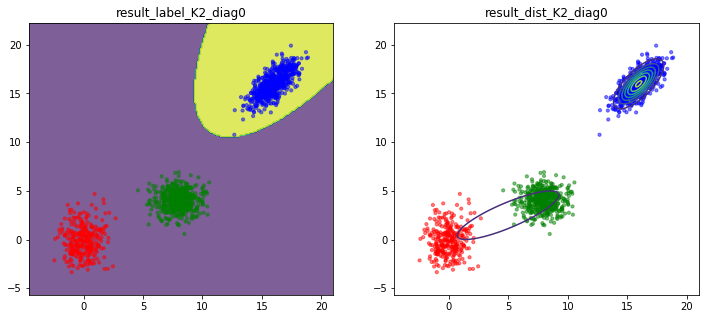

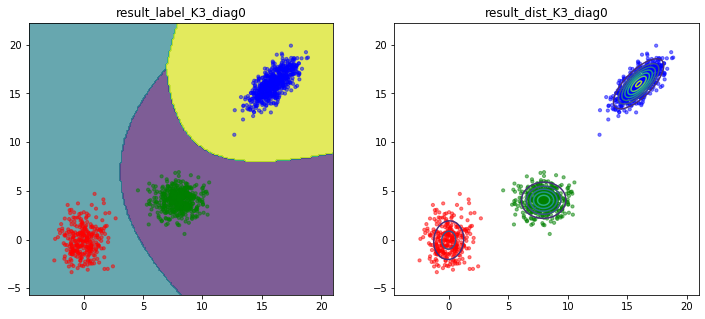

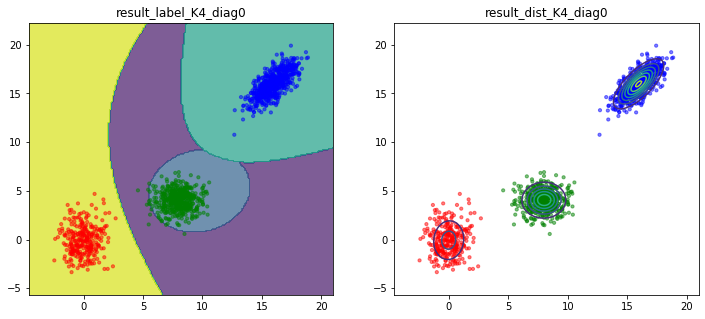

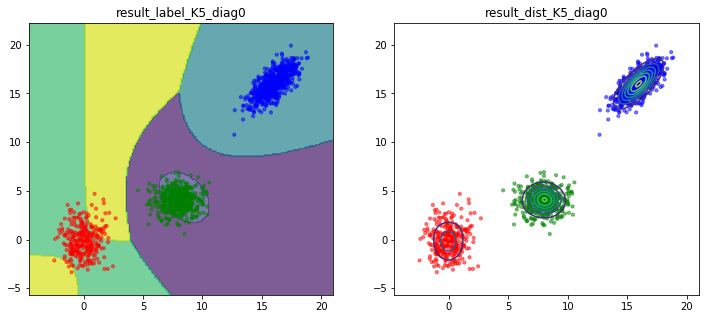

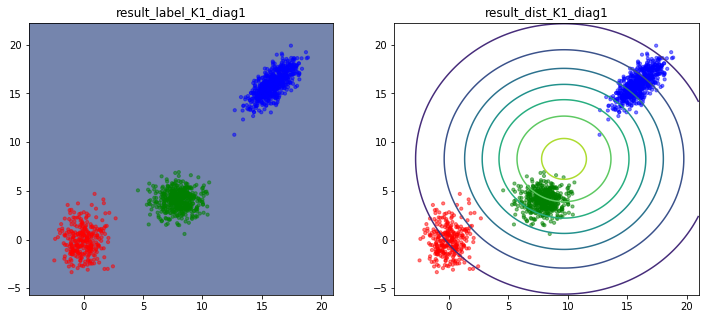

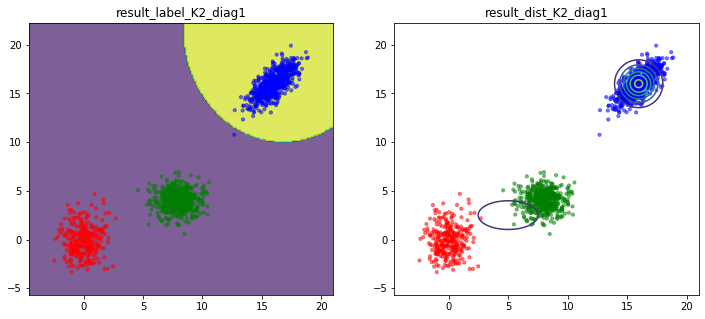

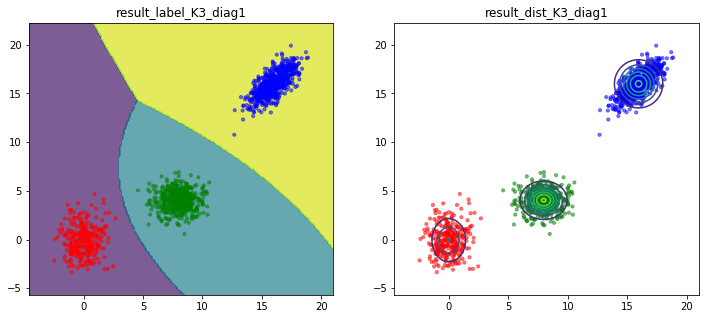

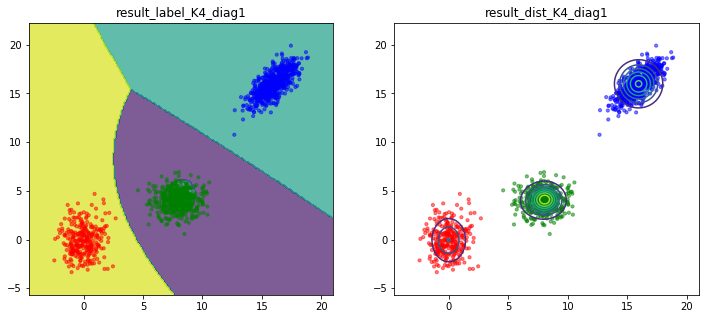

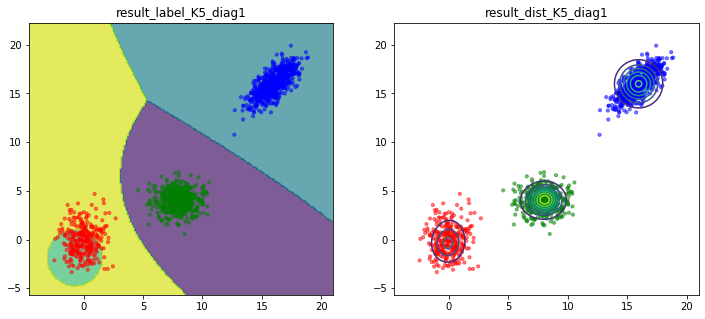

In [221]:
os.makedirs("result",exist_ok=True)
diags = [False, True]
Ks = [1,2,3,4,5]
for diag in diags:
    for K in Ks:
        gmm = GaussianMixtureModel(K=K, diag=diag)
        os.makedirs("images",exist_ok=True)
        os.makedirs("images/gmm_K%d_diag%d"%(K,diag),exist_ok=True)
        os.makedirs("images/gmm2_K%d_diag%d"%(K,diag),exist_ok=True)
        gmm.fit(X, max_iter=30, tol=1e-3, disp_message=True, random_state=3)
        plot_result(gmm, xx, yy, X, labels, K, diag)

In [216]:
os.makedirs("gif",exist_ok=True)

def create_gif(filenames, duration, name=None):
    images = []
    filenames = sorted(glob.glob(filenames+"/*"))
    #print(filenames)
    for filename in filenames:
        try: images.append(Image.open(filename))
        except: pass
    output_file = 'gif/gif_%s.gif' %(name)
    imageio.mimsave(output_file, images, duration=duration)
for diag in diags:
    for K in Ks:
        create_gif("images/gmm_K%d_diag%d"%(K,diag), duration=0.4, name="K%d_diag%d_dist"%(K,diag))
        create_gif("images/gmm2_K%d_diag%d"%(K,diag), duration=0.4, name="K%d_diag%d_loss"%(K,diag))

## Reference
Pattern Recognition and Machine Learning chap.9(https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book)

Fitting Gaussian Mixture Model with Expectatoin Maximization Algorithm(https://nbviewer.jupyter.org/github/amber-kshz/PRML/blob/master/notebooks/Ch09_EM_Algorithm_for_Gaussian_Mixture_Model.ipynb)